# Sea Ice Concentration

From the NSIDC Sea Ice historical and NRT data - calculate climatogy and averages for sea ice conc and extent

In [1]:
#directory paths
_work_dir='/g/data/jk72/as2285/miz/'
_data_dir='/g/data/jk72/MIZ/'

In [2]:
#some constants
CLIMAT_DATES=[1981,2010]
EAST_ANT_LONS=[71,160] #longitudes for east Antartica (easterly)
YEAR=2022
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

In [4]:
#useful py libraries
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.ticker as ticker

from datacube.utils.cog import write_cog
import odc.geo.xr

In [5]:
# import local functions
import sys
sys.path.append(_work_dir)
from utils.sea_ice_conc import sea_ice_conc

%run {_work_dir}utils/plot_tools.ipynb

# Open the dataset

Using the NSIDC Sea Ice Concentration gridded data set, historical monthly averages of sea ice concentration

In [6]:
hist_cdr_xr = xr.open_dataset(
    f'{_data_dir}/NSIDC/G02202_V4/seaice_conc_monthly_sh_197811_202112_v04r00.nc',
    #chunks='auto'
).swap_dims(
    {'tdim':'time', 'x':'xgrid','y':'ygrid'}
).rename(
    {'cdr_seaice_conc_monthly':'cdr_seaice_conc','xgrid':'x','ygrid':'y'}
)

We are going to compare this to the current (2022) conditions:

In [7]:
daily_files = ! ls -d {_data_dir}/NSIDC/G10016_V2/daily/*.nc

In [8]:
daily_da=xr.concat(
    [
        xr.open_dataset(
            iFile,
        ).swap_dims(
            {'tdim':'time', 'x':'xgrid','y':'ygrid'}
        ).rename(
            {'xgrid':'x','ygrid':'y'}
        ) for iFile in daily_files
    ], 
    'time'
)

#we could resample to monlthy, but daily data actually works fine
current_cdr_xr=daily_da#.resample(time='M',label='left', loffset='1D').mean('time')

Put the historical monthly data, and the near real time data in one array:

In [9]:
# If the two datasets have gone out of sync, raise an error.
# This would be amiguous, the historical (released data) and the current (near-real time data) 
# are covering the same times and we don't know which one to use.
if hist_cdr_xr.time_coverage_end>current_cdr_xr.time_coverage_start:
    raise RuntimeError("Times in historical data overlap with near-real time data")

cdr_ds=xr.concat(
    [hist_cdr_xr.cdr_seaice_conc, current_cdr_xr.cdr_seaice_conc], #this is the only data field we use
    'time'
)

#merge the long and lat back in for convenience
cdr_xr=xr.merge(
    [
        cdr_ds,
        hist_cdr_xr.longitude,
        hist_cdr_xr.latitude]
)

cdr_xr

<xarray.Dataset>
Dimensions:          (time: 842, x: 316, y: 332)
Coordinates:
  * time             (time) datetime64[ns] 1978-11-01 1978-12-01 ... 2022-11-20
  * x                (x) float32 -3.938e+06 -3.912e+06 ... 3.912e+06 3.938e+06
  * y                (y) float32 4.338e+06 4.312e+06 ... -3.912e+06 -3.938e+06
Data variables:
    cdr_seaice_conc  (time, y, x) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    longitude        (y, x) float32 ...
    latitude         (y, x) float32 ...
Attributes:
    long_name:            NOAA/NSIDC Climate Data Record of Passive Microwave...
    standard_name:        sea_ice_area_fraction
    units:                1
    flag_values:          [251 252 253 254 255]
    flag_meanings:        pole_hole lakes coastal land_mask missing_data
    datum:                +ellps=urn:ogc:def:crs:EPSG::4326
    grid_mapping:         projection
    reference:            https://nsidc.org/data/g02202/versions/4/
    ancillary_variables:  stdev_of_cdr_seaice_conc_monthly qa_of_cdr_seaice_c...
    valid_range:          [  0 100]
    cell_methods:         tdim: mean

Annoyingly, the area of each grid cell is provided seperately:

In [10]:
datFile=open('/g/data/jk72/MIZ/NSIDC/pss25area_v3.dat', 'rb')
#pss25area_v3.dat: 316 columns x 332 rows
areasDmNd=np.fromfile(datFile, dtype=np.int32).reshape([332,316])

#Divide by 1000 to get km2
areasKmNd=areasDmNd/1000

# Confirm Bounds of Data

We expect the bounds to be the extent of the NSIDC projection (bounds=[[-39.22994121216445, -42.240892341379734], [-41.44603897171838, 135.0]])

Set the geobox too

In [ ]:
del cdr_xr.attrs['grid_mapping']

del cdr_xr.cdr_seaice_conc.attrs['grid_mapping']

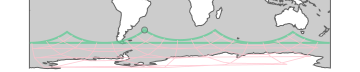

In [28]:
cdr_xr=cdr_xr.odc.assign_crs("epsg:3976")

cdr_xr.odc.geobox

In [29]:
(x1, y1), _, (x2, y2) = cdr_xr.odc.geobox.extent.exterior.to_crs("epsg:4326").points[:3]
bounds = [[y1, x1], [y2, x2]]

In [30]:
bounds

[[-39.22994121216445, -42.240892341379734], [-41.44603897171838, 135.0]]

In [31]:
ant_conc.anoms_da.odc.geobox.extent.exterior.points

[(-3950000.0, 4350000.0),
 (-3950000.0, -3950000.0),
 (3950000.0, -3950000.0),
 (3950000.0, 4350000.0),
 (-3950000.0, 4350000.0)]

# Climatologies for sea ice extent and area

Calculate the climatology and save the result

In [32]:
ant_conc=sea_ice_conc(cdr_xr.cdr_seaice_conc, areasKmNd ) #local class

ant_conc.calc_extent()

ant_conc.calc_gridded_anoms()

/g/data/jk72/as2285/miniconda3/envs/sea-ice-tracker/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/g/data/jk72/as2285/miniconda3/envs/sea-ice-tracker/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/g/data/jk72/as2285/miniconda3/envs/sea-ice-tracker/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/g/data/jk72/as2285/miniconda3/envs/sea-ice-tracker/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/g/data/jk72/as2285/miniconda3/envs/sea-ice-tracker/lib/python3.10/site-packages/numpy/lib/nanfu

ant_conc.conc_climat_ds.to_netcdf(f'{_work_dir}/processing/tracker_data/data/nsidc_climat.nc')

# Tracker Files - COG

In [37]:
START_YEAR='1980'

In [38]:
datetimes_xr=ant_conc.monthly_da.sel(time=slice(START_YEAR,'2050')).time

In [ ]:
for iTime in datetimes_xr:
    
    write_cog(
        100*ant_conc.monthly_da.sel(time=iTime), #consistent 0-100 scale to give %
        f'{_data_dir}tracker_data/sea_ice_conc_25km_cog/nsidc_sea_ice_conc_{iTime.dt.year.values}_{iTime.dt.month.values}.tiff',
        overwrite=True
    )

In [39]:
for iTime in datetimes_xr:
    
    write_cog(
        100*ant_conc.anoms_da.sel(time=iTime), #consistent 0-100 scale to give %
        f'{_data_dir}tracker_data/sea_ice_conc_anoms_25km_cog/nsidc_sea_ice_conc_{iTime.dt.year.values}_{iTime.dt.month.values}.tiff',
        overwrite=True
    )

Ice Edge and 80% contour

In [36]:
from dea_tools.spatial import subpixel_contours

from affine import Affine

In [37]:
for iTime in datetimes_xr[-3:]:

    iDa = ant_conc.monthly_da.sel(time=iTime) ;
    
    lines=subpixel_contours(iDa, z_values=[0.15,0.80], min_vertices=15, crs='epsg:3976')

    lines.to_crs('epsg:4326').to_file(
        f'{_data_dir}/tracker_data/sea_ice_extent/ice_extent_{iTime.dt.year.values}_{iTime.dt.month.values}.json', 
        driver='GeoJSON'
    )


# Tracker Files - Monthly PNG - Archive for Reference

Anoms

In [ ]:
for iTime in datetimes_xr:

    plt.figure(figsize=(79,83), dpi=4, frameon=False, facecolor=None, tight_layout={'pad':0})
    ax=plt.subplot()

    #sea ice conc anoms
    toPlot_anoms=ant_conc.anoms_da.sel(time=iTime)
    cs = plt.contourf(
        toPlot_anoms.x, 
        toPlot_anoms.y, 
        toPlot_anoms.values,
        levels=np.arange(-0.45,0.46,.1),
        extend='both',
        cmap='coolwarm_r'
    )
    
    #Area to add stipling 
    criteria = 2*ant_conc.conc_climat_ds.st_dev.sel(month=iTime.dt.month)
    stipling_area=((toPlot_anoms<-criteria)|(toPlot_anoms>criteria))

    c=plt.pcolor(
        stipling_area.x,
        stipling_area.y,
        np.ma.masked_equal(stipling_area,0),
        hatch='.',
        alpha=0,
        shading='auto',
    )
    
    ax.axis('off')
    
    plt.savefig(
        f'{_data_dir}/tracker_data/sea_ice_conc_anoms/nsidc_sea_ice_conc_anoms_{iTime.dt.year.values}_{iTime.dt.month.values}.svg',
        transparent='True',
    )

    plt.close()

In [ ]:
fig=plt.figure(figsize=(1,5))
ax=plt.subplot()
plt.colorbar(
    mappable=cs,
    cax=ax,
    format=ticker.PercentFormatter(xmax=1),
    label='Concentration Anomaly \n (based on 1981-2010 average)',
    #ticks=[-.45,-.25,-.05,.05,.25,.45]
)

plt.savefig(f'{_data_dir}/tracker_files/sea_ice_conc_anoms_legend.png',
               bbox_inches='tight', transparent="True")

Conc 

In [ ]:
for iTime in datetimes_xr:

    plt.figure(figsize=(316,332), dpi=4, frameon=False, facecolor=None, tight_layout={'pad':0})
    ax=plt.subplot() 

    #sea ice conc anoms
    to_plot=ant_conc.monthly_da.sel(time=iTime)
    to_plot=to_plot.where((to_plot>0.15)*(to_plot<=1))
    
    plt.imshow(
        to_plot.values,
        vmin=0.15,
        vmax=1,
        cmap='Blues_r',
        interpolation='none',
    )

    ax.axis('off')
    
    plt.savefig(
        f'{_data_dir}/tracker_data/sea_ice_conc/nsidc_sea_ice_conc_{iTime.dt.year.values}_{iTime.dt.month.values}.png',
        transparent="True",
    )

    plt.close()

In [ ]:
import matplotlib.colors as colors
import matplotlib.cm as cm

In [ ]:
norm=colors.Normalize(vmin=15,vmax=100)
fig=plt.figure(figsize=(1,5))
ax=plt.subplot()
cb=fig.colorbar(
    cm.ScalarMappable(norm=norm, cmap='Blues_r'),
    label='Sea Ice Concentration (%)',
    cax=ax,
    #aspect=2.5
)
cb.set_ticks([15,30,45,60,75,90,100])


plt.savefig(f'{_data_dir}/tracker_files/sea_ice_conc_legend.png',
               bbox_inches='tight', transparent="True")

# Tracker files - Bremen Daily

In [6]:
import os
import pandas as pd
from PIL import Image


In [7]:
bremen_files= ! ls -d {_data_dir}/Bremen/netcdf/*.nc

blues_cm=plt.get_cmap("Blues_r",10)

for iFile in bremen_files[-1:]:

    datetime=pd.to_datetime(
        os.path.basename(iFile)[slice(16,24)],
        format='%Y%m%d'
    )
    
    # plt.figure(figsize=(1327,1264), dpi=1, frameon=False, facecolor=None, tight_layout={'pad':0}) #size and dpi set to be equal to the number of pixels
    # ax=plt.subplot() 

    #sea ice conc anoms
    to_plot=xr.open_dataset(iFile)
    to_plot=to_plot.z 
    to_plot=to_plot[-1:0:-1,:].where((to_plot>15)*(to_plot<=100)) 
    
    to_plot=to_plot.odc.assign_crs("epsg:3031")

    write_cog(to_plot, f'{_data_dir}/bremen_cog/bremen_sea_ice_conc_{datetime.year}_{datetime.month}_{datetime.day}.tif')

    # png_image.quantize().save(
    #     f'{_data_dir}/tracker_files/hr_sea_ice_conc_test/bremen_sea_ice_conc_{datetime.year}_{datetime.month}_{datetime.day}.png'
    # )

blues_cm=plt.get_cmap("Blues_r",1024)

for iFile in bremen_files[-60:-59]:

    datetime=pd.to_datetime(
        os.path.basename(iFile)[slice(16,24)],
        format='%Y%m%d'
    )
    
    # plt.figure(figsize=(1327,1264), dpi=1, frameon=False, facecolor=None, tight_layout={'pad':0}) #size and dpi set to be equal to the number of pixels
    # ax=plt.subplot() 

    #sea ice conc anoms
    to_plot=xr.open_dataset(iFile)
    to_plot=to_plot.z 
    to_plot=to_plot[-1:0:-1,:].where((to_plot>15)*(to_plot<=100)) 

    colored_xr=to_plot.odc.colorize(cmap=blues_cm, 
                                    vmin=15, vmax=100)

    png_image=Image.fromarray(colored_xr.values,mode="RGBA").quantize()

    png_image.save(
        f'{_data_dir}/tracker_files/hr_sea_ice_conc/bremen_sea_ice_conc_{datetime.year}_{datetime.month}_{datetime.day}.png'
    )

import matplotlib.colors as colors
import matplotlib.cm as cm

fig=plt.figure(figsize=(1,5))
ax=plt.subplot()
cb=fig.colorbar(
    cm.ScalarMappable(norm=colors.Normalize(vmin=0,vmax=100),cmap=blues_cm),
    label='Sea Ice Concentration (%)',
    cax=ax,
    #aspect=2.5
)
cb.set_ticks([15,30,45,60,75,90,100])


plt.savefig(f'{_data_dir}/tracker_files/hr_sea_ice_conc_legend.png', bbox_inches='tight', transparent="True")

for iFile in bremen_files[-1:]:

    datetime=pd.to_datetime(
        os.path.basename(iFile)[slice(16,24)],
        format='%Y%m%d'
    )
    
    plt.figure(figsize=(1327,1264), dpi=1, frameon=False, facecolor=None, tight_layout={'pad':0}) #size and dpi set to be equal to the number of pixels
    ax=plt.subplot() 

    #sea ice conc anoms
    to_plot=xr.open_dataset(iFile)
    to_plot=to_plot.z 
    to_plot=to_plot.where((to_plot>15)*(to_plot<=100)) 
    
    plt.imshow(
        to_plot[-1:0:-1,:],
        vmin=15,
        vmax=100,
        cmap='Blues_r',
        interpolation='none'
    )

    ax.axis('off')
    
    # plt.savefig(
    #     f'{_data_dir}/tracker_files/hr_sea_ice_conc/bremen_sea_ice_conc_{datetime.year}_{datetime.month}_{datetime.day}.png',
    # )
    
    # plt.close()

Confirm the extent is the same as nsidc cdr data

In [ ]:
to_plot.odc.assign_crs('epsg:3412').odc.geobox.extent.exterior.to_crs("epsg:4326").points[:3]

# A python only map

In [ ]:
from ipyleaflet import basemaps,projections, WMSLayer
from ipywidgets import Layout
from sidecar import Sidecar
import leafmap


In [ ]:
POLAR3031 = dict(
    name='EPSG:3031',
    custom=True,
    proj4def="""+proj=stere +lat_0=-90 +lat_ts=-71 +lon_0=0 +k=1
        +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs""",
    bounds =[[-2822131.5,-3057369.25],[3744213.75,3822194.25]]
)

In [ ]:
f'{_data_dir}/tracker_files/sea_ice_conc/nsidc_sea_ice_conc_{iTime.dt.year.values}_{iTime.dt.month.values}.png'

In [ ]:
conc_dict_dict={}
anoms_dict={}
for iTime in datetimes_xr[:-3]:
    conc_dict[f'{iTime.dt.year.values}-{iTime.dt.month.values}']=leafmap.ImageOverlay(
        url=f'{_data_dir}/tracker_files/sea_ice_conc/nsidc_sea_ice_conc_{iTime.dt.year.values}_{iTime.dt.month.values}.png', 
        bounds=bounds, 
        opacity=1,
        name='Sea Ice Concentration'
    )
    """anoms_dict[f'{iTime.dt.year.values}-{iTime.dt.month.values}']=leafmap.ImageOverlay(
        url=f'{_data_dir}/tracker_files/sea_ice_conc_anoms/nsidc_sea_ice_conc_anoms_{iTime.dt.year.values}_{iTime.dt.month.values}.svg', 
        bounds=bounds, 
        opacity=1,
        name='Concentration Anomaly'
    )"""

In [ ]:
spsLayout=Layout(width='800px', height='1200px')

In [ ]:
m = leafmap.Map(center=(-70, 135),
        zoom=1,
        layout=spsLayout,
        basemap=basemaps.NASAGIBS.BlueMarble3031,
        crs=projections.EPSG3031)

m.add_wms_layer(url='http://geos.polarview.aq/geoserver/wms', layers='polarview:coastS10', format='image/png',  transparent=True, attribution='Polarview', crs=POLAR3031, name='Coastline')

m.add_time_slider(
    conc_dict
)
"""m.add_time_slider(
    anoms_dict,
)"""

m.add_wms_layer(url='http://geos.polarview.aq/geoserver/wms', layers='polarview:graticuleS', format='image/png',  transparent=True, attribution='Polarview', crs=POLAR3031, name='Graticule')


display(m)

#sc = Sidecar(title="name")
#with sc:
#display(m)